In [4]:
import pandas as pd 
from pandas.api.types import is_datetime64_any_dtype

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from skrub import TableReport
import folium
import holidays
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import importlib
import bike_count as bc # My personal module
from flaml import AutoML
from prophet import Prophet


c:\Users\lucie\anaconda3\envs\bikes-count\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# EDA

In [13]:
data = pd.read_parquet(Path("data") / "train.parquet").reset_index(drop=True)

In [6]:
TableReport(data)

Processing column  12 / 12


,,,,,,,,,,,,


##### Counter Locations in Paris

In [9]:
m = folium.Map(location=data[['latitude', 'longitude']].mean(axis=0), zoom_start=12, tiles = 'Cartodb Positron')

for _, row in (
    data[['counter_name', 'latitude', 'longitude']]
    .drop_duplicates('counter_name')
    .iterrows()
):
    folium.Marker(
        row[['latitude', 'longitude']]
        .values
        .tolist(),
        popup=row['counter_name']
    ).add_to(m)

m

c:\Users\diane\anaconda3\envs\bikes-count\lib\site-packages\folium\utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


fun fact: tour de france le 18 juillet 2021

In [14]:
date = '2021-07-18'
counter = 'Pont de la Concorde S-N'
tdf = data[(data['date'].astype(str).str.contains(date)) & (data['counter_name'] == counter)]
tdf['bike_count'].sum()

np.float64(227.0)

##### Time Series Analysis

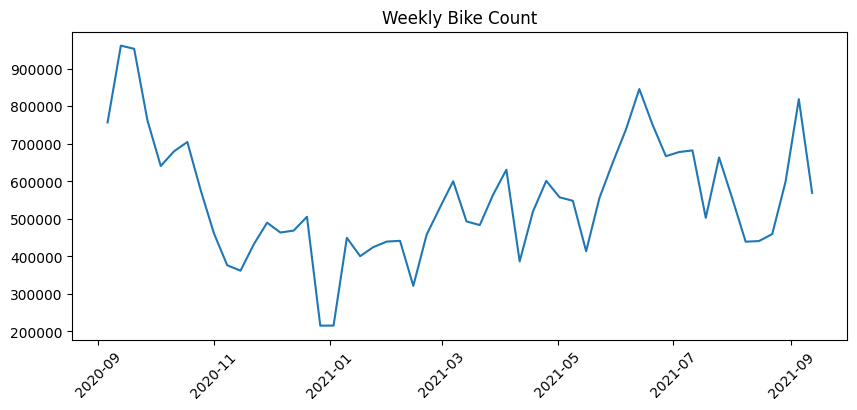

In [79]:
plt.figure(figsize=(10,4))
plt.plot(data.groupby(pd.Grouper(freq='1W', key='date'))['bike_count'].sum())
plt.title('Weekly Bike Count')
plt.xticks(rotation=45)
plt.show()

We can directly see that there are almost twice as much cyclists during summer than during winter. This lets us believe that TEMPERATURE plays a crucial role (keep that in mind when incorporating the external data)

In [70]:
counters = data['counter_name'].drop_duplicates().values.tolist()

In [71]:
def plotting_counters(counter, start, end):

    global_counter_average = data[data['counter_name'] == counter]['bike_count'].mean()

    counter_data = data[(
        (data['counter_name'] == counter) &
        (data['date'] > pd.to_datetime(start)) &
        (data['date'] < pd.to_datetime(end))
    )].sort_values(by='date', ascending=False)

    plt.figure(figsize=(10, 4))

    plt.plot(counter_data['date'], counter_data['bike_count'])
    plt.title(f'{counter} average bike count between {start} and {end}')
    plt.axhline(global_counter_average, color='r', linestyle='--', alpha=0.7, label=f'{counter} Global Average Bike Count')
    plt.axhline(counter_data['bike_count'].mean(), color='black', linestyle='--', alpha=0.7, label='Average for the period')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

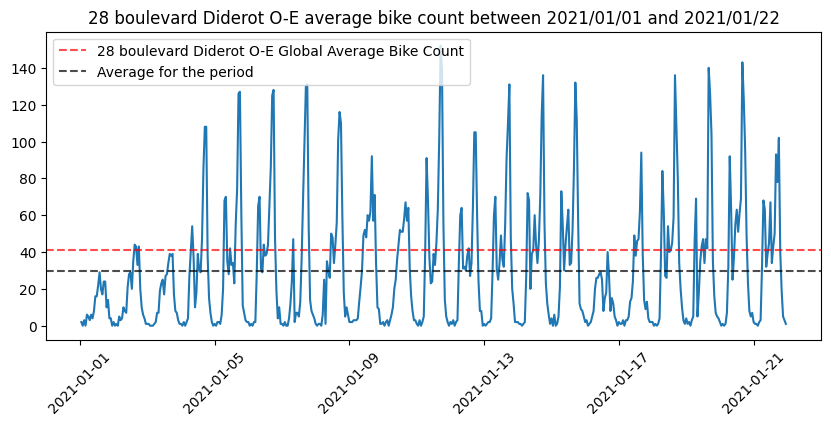

In [72]:
plotting_counters(counters[1], '2021/01/01', '2021/01/22')

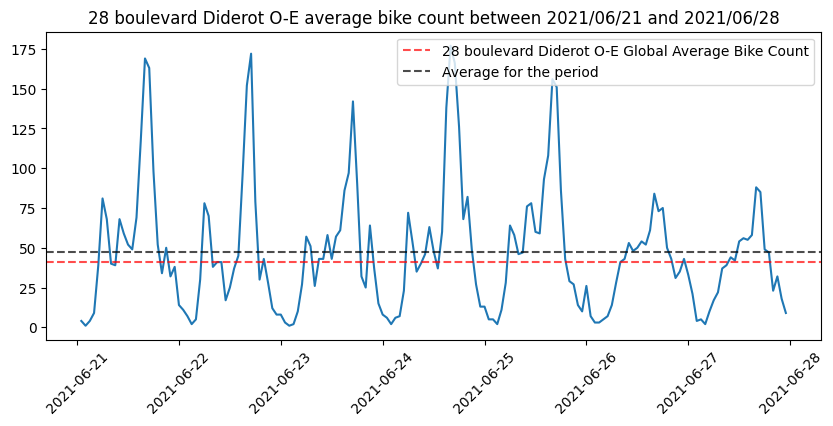

In [74]:
plotting_counters(counters[1], '2021/06/21', '2021/06/28')

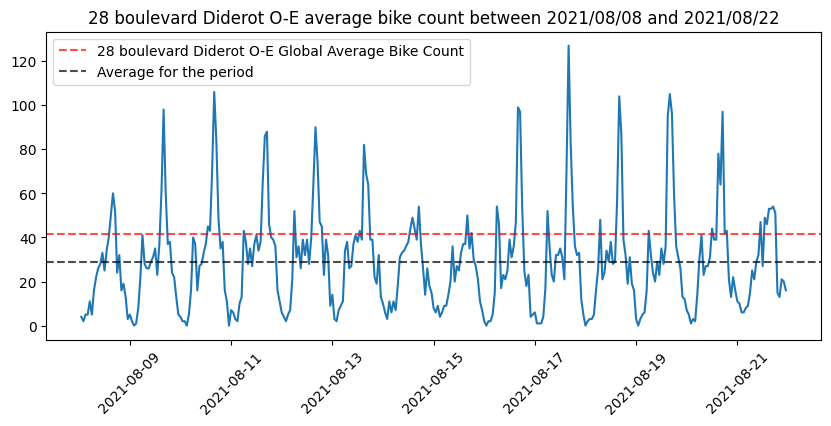

In [19]:
plotting_counters(counters[1], '2021/08/08', '2021/08/22')

We see a clear correlation between working days/hours and bike count in Paris. 

During colder times, we notice much less bikes passing through the same counters, and during summer we notice less bikes as well, surely because people are on vacation.

##### Date Encoding

In [20]:
date_data = pd.concat([bc._encode_date(data[['date']]), data[['bike_count']]], axis=1)
date_data

,month_day,week_day,year,month,hour,is_weekend,season,is_holiday,bike_count
0,1,2,2020,9,2,0,fall,0,0.0
1,1,2,2020,9,3,0,fall,0,1.0
2,1,2,2020,9,4,0,fall,0,0.0
3,1,2,2020,9,15,0,fall,0,4.0
4,1,2,2020,9,18,0,fall,0,9.0
...,...,...,...,...,...,...,...,...,...
496822,9,4,2021,9,6,0,fall,0,445.0
496823,9,4,2021,9,10,0,fall,0,145.0
496824,9,4,2021,9,15,0,fall,0,218.0
496825,9,4,2021,9,22,0,fall,0,21.0


##### Date Elements Analysis

In [21]:
date_data.groupby(['is_holiday'])['bike_count'].mean()

is_holiday
0    61.082057
1    30.957789
Name: bike_count, dtype: float64

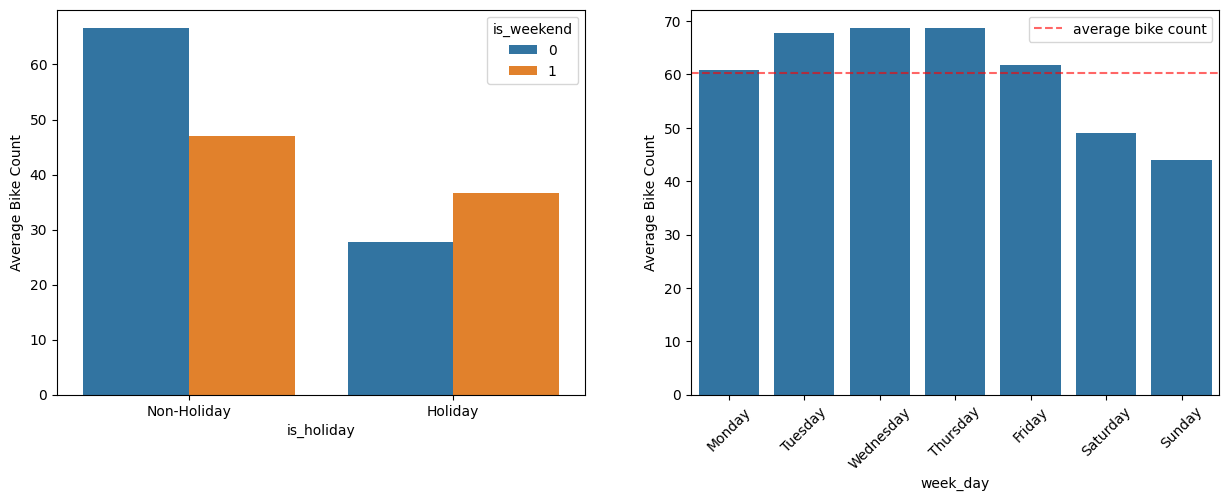

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(
    data=(date_data
          .groupby(['is_holiday', 'is_weekend'])['bike_count']
          .mean()
          .reset_index()  
    ),
    x='is_holiday',  
    y='bike_count',  
    hue='is_weekend'  
)

plt.ylabel('Average Bike Count')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday']) 

plt.subplot(1, 2, 2)
sns.barplot(
    data=(date_data
          .groupby('week_day')['bike_count']
          .mean()
          .reset_index()
    ),
    x='week_day',
    y='bike_count'
)
plt.axhline(data['bike_count'].mean(), color='r', linestyle = '--', alpha=0.6, label = 'average bike count')
plt.ylabel('Average Bike Count')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout
plt.show()


Less bikes when it's a french holiday, and there are more bikes in the middle of the week. 

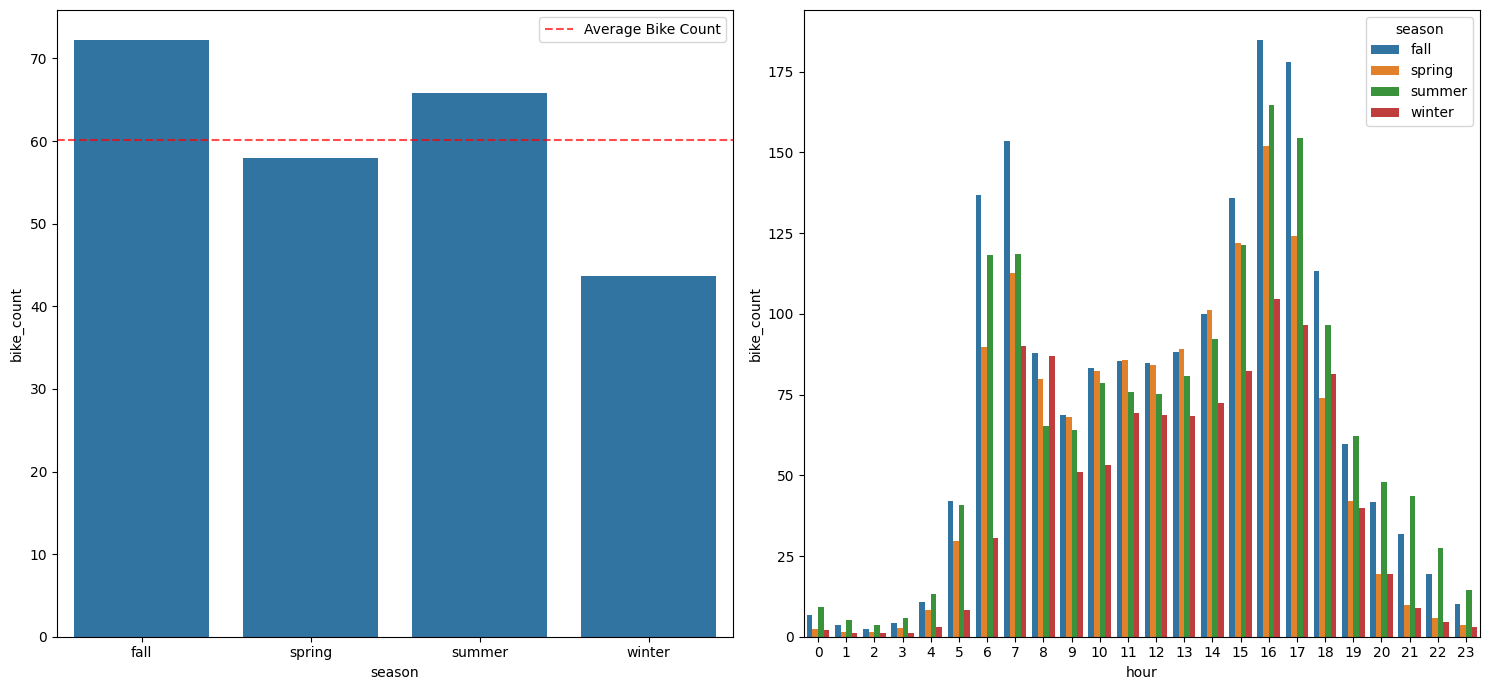

In [23]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.barplot(
    data=(date_data
          .groupby(['season'])['bike_count']
          .mean()
          .reset_index()
    ),
    x='season',
    y='bike_count',
)
plt.axhline(date_data['bike_count'].mean(), color='r', alpha=0.7, linestyle='--', label = 'Average Bike Count')
plt.legend()

plt.subplot(1, 2, 2)
sns.barplot(
    data=(date_data
          .groupby(['hour', 'season'])['bike_count']
          .mean()
          .reset_index()
    ),
    x='hour',
    y='bike_count',
    hue='season'
)

plt.tight_layout()
plt.show()

There are more bikes in Fall and Summer. Take a closer look at hourly trends per season

Mean bike count per counter

In [24]:
mean_counts = data.groupby('counter_name')['bike_count'].mean().reset_index()
mean_counts.columns = ['counter', 'mean_bike_count']
mean_counts.sort_values('mean_bike_count', inplace=True, ascending=False)
mean_counts.head()

C:\Users\diane\AppData\Local\Temp\ipykernel_115104\2469380877.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_counts = data.groupby('counter_name')['bike_count'].mean().reset_index()


,counter,mean_bike_count
49,Totem 73 boulevard de Sébastopol S-N,221.999889
47,Totem 64 Rue de Rivoli O-E,172.913974
48,Totem 73 boulevard de Sébastopol N-S,166.916871
20,67 boulevard Voltaire SE-NO,125.982282
46,Totem 64 Rue de Rivoli E-O,113.202028


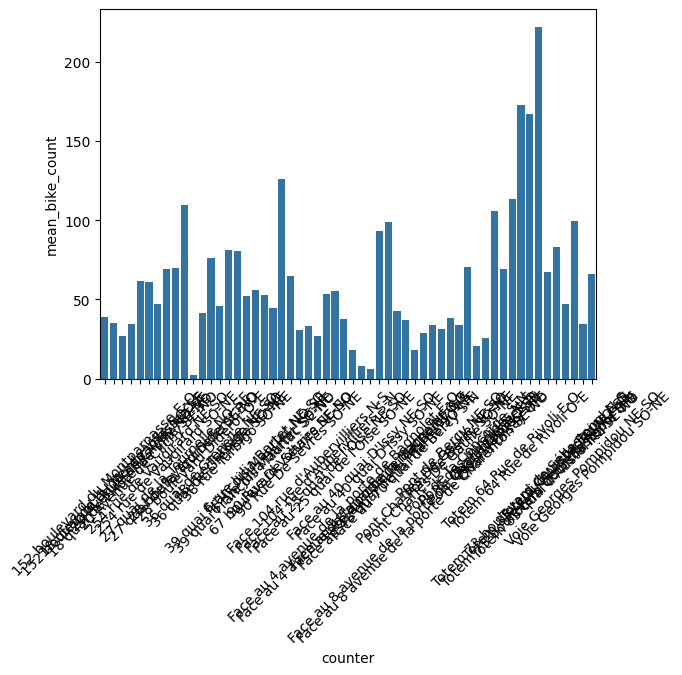

In [25]:
sns.barplot(
    data = mean_counts.sort_values('mean_bike_count', ascending=False),
    x='counter',
    y='mean_bike_count' 
)
plt.xticks(rotation=45)
plt.show()

##### is the 'counter_installation_date' column important?

In [26]:
data.groupby(pd.Grouper(freq='6M', key='counter_installation_date'))['bike_count'].mean()

C:\Users\diane\AppData\Local\Temp\ipykernel_115104\3345018808.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.groupby(pd.Grouper(freq='6M', key='counter_installation_date'))['bike_count'].mean()


counter_installation_date
2013-01-31     21.785157
2013-07-31           NaN
2014-01-31           NaN
2014-07-31           NaN
2015-01-31           NaN
2015-07-31           NaN
2016-01-31           NaN
2016-07-31           NaN
2017-01-31           NaN
2017-07-31     42.319729
2018-01-31     50.509039
2018-07-31    125.982282
2019-01-31     50.961635
2019-07-31           NaN
2020-01-31     56.360093
2020-07-31     90.441101
2021-01-31     58.326593
Freq: 6ME, Name: bike_count, dtype: float64

In [31]:
data.groupby(data['counter_installation_date'].dt.year)['counter_installation_date'].value_counts()

counter_installation_date  counter_installation_date
2013                       2013-01-18                   17948
2017                       2017-07-12                   35896
                           2017-12-15                   17038
2018                       2018-11-28                   35896
                           2018-11-29                   35896
                           2018-11-30                   17948
                           2018-12-07                   17936
                           2018-06-27                    8974
2019                       2019-11-14                   35896
                           2019-11-06                   26922
                           2019-11-07                   26922
                           2019-09-04                   17948
                           2019-11-01                   17948
                           2019-11-05                   17948
                           2019-12-10                   17948
                 

# Model Testing

#### First Linear Model

In [40]:
X, y = bc.get_model_data()
X_train, X_valid, y_train, y_valid = bc.train_test_temporal(X, y, '30 days')
pipe = bc.base_pipeline()

First Pipeline for baseline 

In [41]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000020390622830>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_date at 0x0000020390620160>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month_day', 'week_day',
                                                   'year', 'month', 'hour',
                                                   'is_weekend',
                                                   'is_holiday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('linearregression', LinearRegression())])

In [42]:
train_pred = pipe.predict(X_train)
valid_pred = pipe.predict(X_valid)

In [43]:
print(
    f"Train set, RMSE={root_mean_squared_error(y_train, train_pred):.5f}"
)
print(
    f"Valid set, RMSE={root_mean_squared_error(y_valid, valid_pred):.5f}"
)

Train set, RMSE=0.79565
Valid set, RMSE=0.74598


In [44]:
print("Baseline mean prediction.")
print(
    f"Train set, RMSE={root_mean_squared_error(y_train, np.full(y_train.shape, y_train.mean())):.2f}"
)
print(
    f"Test set, RMSE={root_mean_squared_error(y_valid, np.full(y_valid.shape, y_valid.mean())):.2f}"
)

Baseline mean prediction.
Train set, RMSE=1.67
Test set, RMSE=1.44


In [45]:
test_data = pd.read_parquet('data/final_test.parquet')
test_pred = pipe.predict(test_data)

test_df = pd.DataFrame({
    'Id': range(0, len(test_pred)), 
    'log_bike_count': test_pred           
})

test_df.to_csv('test_df_linear.csv', index=False)

#### Random Forest

In [10]:
X, y = bc.get_model_data()
X_train, X_valid, y_train, y_valid = bc.train_test_temporal(X, y, '30 days')
pipe = bc.rf_tuned_pipeline()

In [11]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_date at 0x00000270873E9940>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month_day', 'week_day',
                                                   'year', 'month', 'hour',
                                                   'is_weekend', 'season',
                                                   'is_holiday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=20, n_jobs=-1))])

In [22]:
train_pred = pipe.predict(X_train)
valid_pred = pipe.predict(X_valid)

print(
    f"Train set, RMSE={root_mean_squared_error(y_train, train_pred):.5f}"
)
print(
    f"Valid set, RMSE={root_mean_squared_error(y_valid, valid_pred):.5f}"
)

Train set, RMSE=0.64835
Valid set, RMSE=0.57894


In [ ]:
test_data = pd.read_parquet('data/final_test.parquet')
test_pred = pipe.predict(test_data)

test_df = pd.DataFrame({
    'Id': range(0, len(test_pred)), 
    'log_bike_count': test_pred           
})

test_df.to_csv('test_df_rf.csv', index=False)

#### Simple XGBoost

In [21]:
importlib.reload(bc)

<module 'bike_count' from 'c:\\Users\\lucie\\XHEC Python for Data Science\\bike_count_ldmh\\bike_count.py'>

In [22]:
X, y = bc.get_model_data()
X_train, X_valid, y_train, y_valid = bc.train_test_temporal(X, y, '30 days')
pipe = bc.xgb_tuned_pipeline()

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001A1873C5990>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_date at 0x000001A183E85510>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['t']),
                                                 ('date',
                                                  OneHotEncoder(handle_unknown='infrequent_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [24]:
train_pred = pipe.predict(X_train)
valid_pred = pipe.predict(X_valid)

print(
    f"Train set, RMSE={root_mean_squared_error(y_train, train_pred):.5f}"
)
print(
    f"Valid set, RMSE={root_mean_squared_error(y_valid, valid_pred):.5f}"
)

Train set, RMSE=0.65960
Valid set, RMSE=0.57296


In [25]:
test_data = pd.read_parquet('data/final_test.parquet')
test_pred = pipe.predict(test_data)

test_df = pd.DataFrame({
    'Id': range(0, len(test_pred)), 
    'log_bike_count': test_pred           
})

test_df.to_csv('test_df_xgb_4.csv', index=False)

### Ridge Regression

In [17]:
X, y = bc.get_model_data()
X_train, X_valid, y_train, y_valid = bc.train_test_temporal(X, y, '30 days')
pipe = bc.ridge_pipeline()

In [18]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x000001A1FDAE56C0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_date at 0x000001A1FDAE4CA0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['month_day', 'week_day',
                                                   'year', 'month', 'hour',
                                                   'is_weekend',
                                                   'is_holiday']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('ridge', Ridge())])

In [19]:
train_pred = pipe.predict(X_train)
valid_pred = pipe.predict(X_valid)

print(
    f"Train set, RMSE={root_mean_squared_error(y_train, train_pred):.5f}"
)
print(
    f"Valid set, RMSE={root_mean_squared_error(y_valid, valid_pred):.5f}"
)

Train set, RMSE=0.79565
Valid set, RMSE=0.74592


### Autres Idées: 
- Entrainer le modele sur le validation set et faire des prédictions avec ca 
- Entrainer le modele avec TOUTE la donnée et faires prédictions sur ca

#### Entrainement sur validation set

In [4]:
X, y = bc.get_model_data()
X_train, X_valid, y_train, y_valid = bc.train_test_temporal(X, y, '90 days')

In [ ]:
# du coup on utilise X_valid ici, j'ai extend le validation set à 3 mois pour utiliser plus de données

In [5]:
pipe = bc.xgb_tuned_pipeline()
pipe.fit(X_valid, y_valid)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000024D8B97A290>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_date at 0x0000024D8A6E56C0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['t']),
                                                 ('date',
                                                  OneHotEncoder(handle_unknown='infrequent_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [6]:
valid_pred = pipe.predict(X_valid)

print(
    f"Valid set, RMSE={root_mean_squared_error(y_valid, valid_pred):.5f}"
)

Valid set, RMSE=0.54774


In [7]:
test_data = pd.read_parquet('data/final_test.parquet')
test_pred = pipe.predict(test_data)

test_df = pd.DataFrame({
    'Id': range(0, len(test_pred)), 
    'log_bike_count': test_pred           
})

test_df.to_csv('test_df_xgb_using_validation.csv', index=False)

Resulting kaggle score: 0.8463

#### Entrainement sur tout le dataset

In [8]:
X, y = bc.get_model_data()
pipe = bc.xgb_tuned_pipeline()
pipe.fit(X, y)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x0000024D8B97A290>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_date at 0x0000024D8A6E56C0>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['t']),
                                                 ('date',
                                                  OneHotEncoder(handle_unknown='infrequent_...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None, min_child_weight=1,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=42, ...))])

In [9]:
y_pred = pipe.predict(X)

print(
    f"Valid set, RMSE={root_mean_squared_error(y, y_pred):.5f}"
)

Valid set, RMSE=0.65514


In [10]:
test_data = pd.read_parquet('data/final_test.parquet')
test_pred = pipe.predict(test_data)

test_df = pd.DataFrame({
    'Id': range(0, len(test_pred)), 
    'log_bike_count': test_pred           
})

test_df.to_csv('test_df_xgb_using_all.csv', index=False)

## Auto ML

In [31]:
importlib.reload(bc)

X, y = bc.get_model_data()
X_train, X_valid, y_train, y_valid = bc.train_test_temporal(X, y, '30 days')
pipe = bc.preprocess_pipeline()

In [32]:
pipe.fit(X_train, y_train)
X_train_transformed = pipe.transform(X_train)  # Transformation de l'entraînement
X_valid_transformed = pipe.transform(X_valid)  # Transformation de la validation


flaml = AutoML()
flaml_settings = {
    "time_budget": 120,
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": "flaml_rmse.log",
    "estimator_list": ['xgboost', 'lgbm'],
}

flaml.fit(X_train_transformed, y_train, **flaml_settings)

[flaml.automl.logger: 12-03 16:05:28] {1728} INFO - task = regression
[flaml.automl.logger: 12-03 16:05:28] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-03 16:05:28] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 12-03 16:05:28] {1955} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm']
[flaml.automl.logger: 12-03 16:05:28] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-03 16:05:28] {2393} INFO - Estimated sufficient time budget=33194s. Estimated necessary time budget=33s.
[flaml.automl.logger: 12-03 16:05:28] {2442} INFO -  at 0.3s,	estimator xgboost's best error=1.5656,	best estimator xgboost's best error=1.5656
[flaml.automl.logger: 12-03 16:05:28] {2258} INFO - iteration 1, current learner lgbm


TypeError: 'NoneType' object is not callable

In [21]:
train_pred = flaml.predict(X_train_transformed)
valid_pred = flaml.predict(X_valid_transformed)

print(
    f"Train set, RMSE={root_mean_squared_error(y_train, train_pred):.5f}"
)
print(
    f"Valid set, RMSE={root_mean_squared_error(y_valid, valid_pred):.5f}"
)

Train set, RMSE=0.35090
Valid set, RMSE=0.50354


In [ ]:
test_data = pd.read_parquet('data/final_test.parquet')
test_transformed = pipe.transform(test_data)

test_pred = flaml.predict(test_transformed)

test_df = pd.DataFrame({
    'Id': range(0, len(test_pred)), 
    'log_bike_count': test_pred           
})

test_df.to_csv('test_df_automl.csv', index=False)